# Using Machine Learning

## INITIALISATION


In [318]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ta.momentum import RSIIndicator
from ta.trend import MACD
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit     
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


In [267]:
symbols = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS"]

In [268]:
for symbol in symbols:   
    stock = yf.Ticker(symbol)
    info = stock.info
    print(f"Symbol: {symbol}")
    print(f"Name: {info.get('shortName', 'N/A')}")
    print(f"Market: {info.get('market', 'N/A')}")
    print(f"Sector: {info.get('sector', 'N/A')}")
    print("-" * 30)

Symbol: RELIANCE.NS
Name: RELIANCE INDUSTRIES LTD
Market: in_market
Sector: Energy
------------------------------
Symbol: HDFCBANK.NS
Name: HDFC BANK LTD
Market: in_market
Sector: Financial Services
------------------------------
Symbol: INFY.NS
Name: INFOSYS LIMITED
Market: in_market
Sector: Technology
------------------------------


## DATA VISUALISATION


Historical Data for HDFCBANK.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  974.173 |  975.123 |  942.886 |  951.432 | 1.58918e+07 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  957.129 | 1007.5   |  952.381 |  989.081 | 3.01531e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  995.063 | 1002.52  |  968.523 |  975.692 | 1.66107e+07 |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  984.665 | 1001.76  |  974.458 |  988.179 | 1.68234e+07 |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  982.624 |  994.351 |  969.093 |  991.17  | 1.24184e+07 |           0 |           

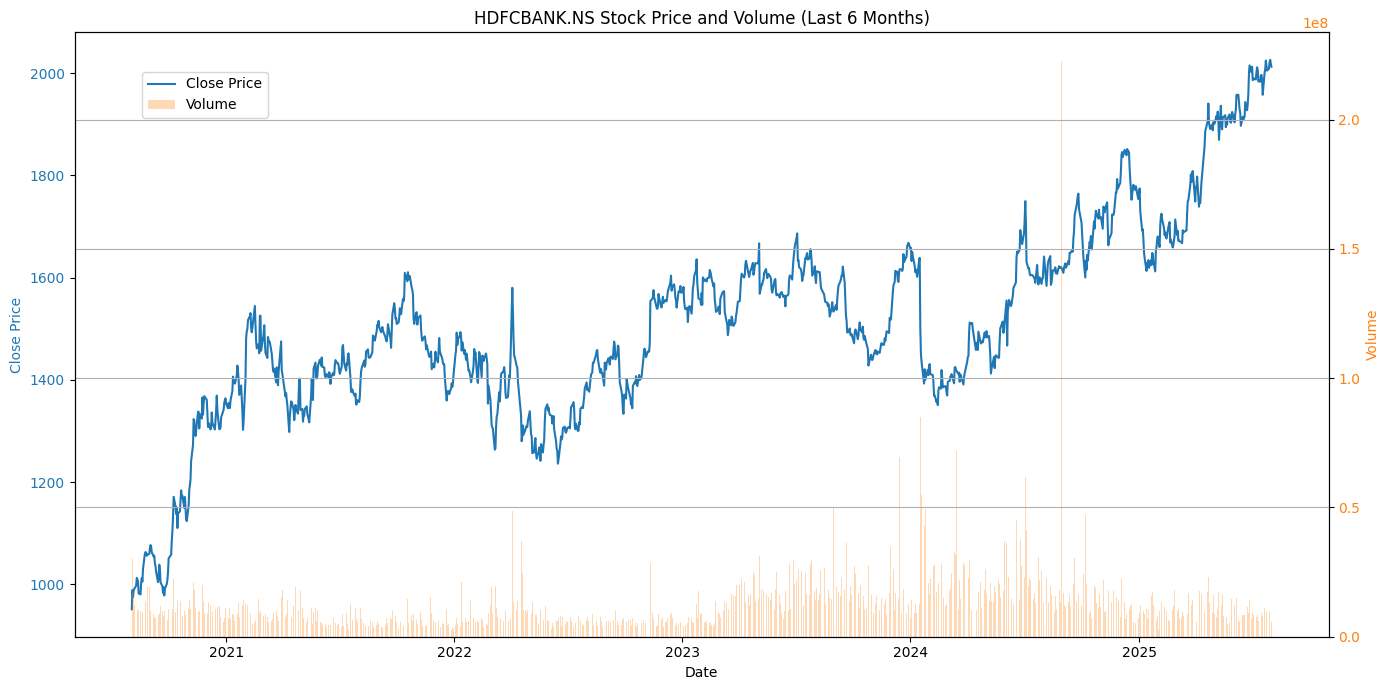

In [269]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'HDFCBANK.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Historical Data for RELIANCE.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  933.838 |  936.433 |  911.896 |  914.582 | 4.67154e+07 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  919.862 |  986.51  |  910.598 |  979.044 | 9.20411e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  987.42  |  999.712 |  964.34  |  968.05  | 7.455e+07   |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  981.957 |  986.829 |  959.559 |  971.532 | 4.9323e+07  |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  969.575 |  982.322 |  965.205 |  977.155 | 3.29844e+07 |           0 |           

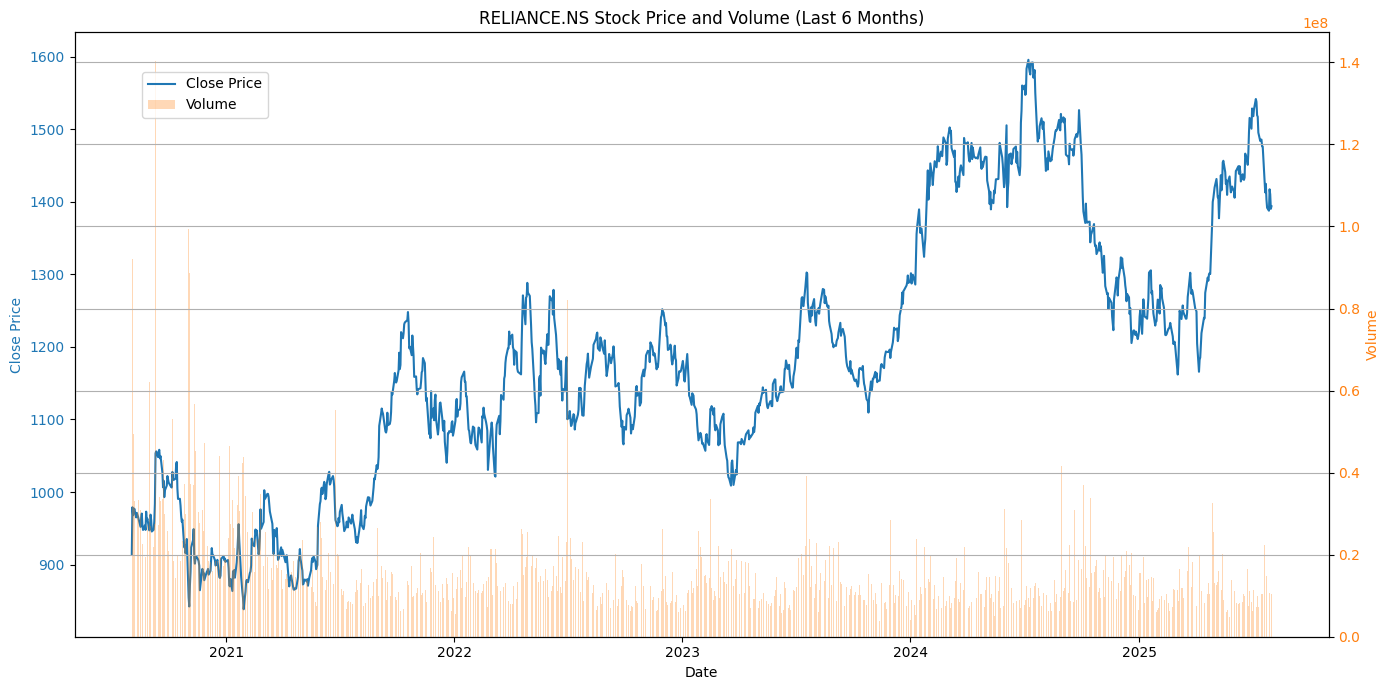

In [270]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'RELIANCE.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Historical Data for INFY.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  853.778 |  858.581 |  842.617 |  851.021 | 8.47979e+06 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  854.179 |  863.294 |  836.48  |  844.751 | 1.11332e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  846.663 |  854.623 |  834.479 |  840.171 | 9.61418e+06 |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  847.998 |  866.585 |  838.215 |  863.428 | 1.09765e+07 |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  862.183 |  862.183 |  843.996 |  845.685 | 8.01095e+06 |           0 |              0

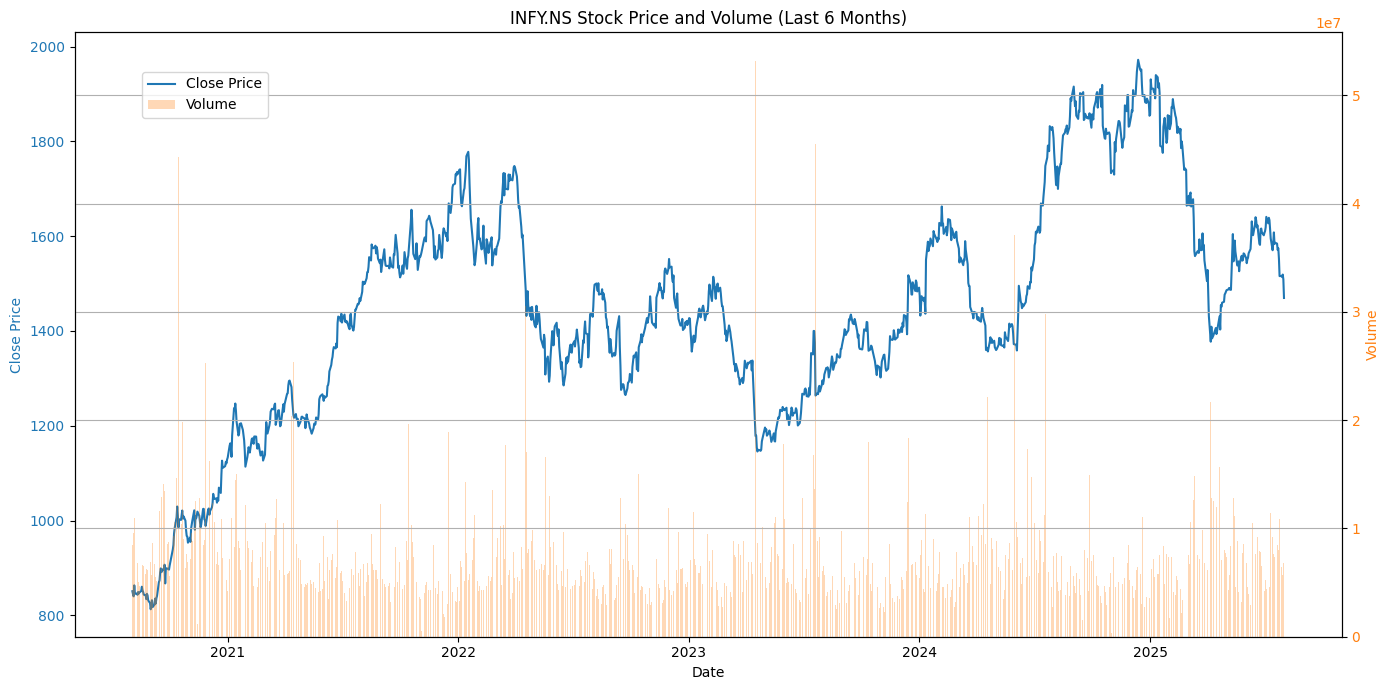

In [271]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'INFY.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

## PREPROCESSING THE DATA

In [307]:
def preprocess_stock(df, rsi_threshold=30):
    df = df.copy()
    
    # Technical Indicators
    df["RSI"] = RSIIndicator(df["Close"], window=14).rsi()
    df["MACD"] = MACD(df["Close"]).macd()
    df["MACD_Signal"] = MACD(df["Close"]).macd_signal()
    df["SMA_20"] = df["Close"].rolling(window=20).mean()
    df["SMA_50"] = df["Close"].rolling(window=50).mean()
    df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
    df["Volatility"] = df["Close"].rolling(window=10).std()
    
    # Strategy Signals
    df["Buy_Signal"] = ((df["RSI"] < rsi_threshold) & (df["SMA_20"] > df["SMA_50"]).astype(int))
    df["Logic_Signal"] = df["Buy_Signal"]  # For ML vs. Logic comparison later
    df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    
    return df.dropna()

In [308]:
symbol_infy = 'INFY.NS'
print(f"Preprocessed data for {symbol_infy}")
data_infy = yf.Ticker(symbol_infy).history(period='5y')
processed_infy = preprocess_stock(data_infy)
processed_infy.head()

Preprocessed data for INFY.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI,MACD,MACD_Signal,SMA_20,SMA_50,EMA_20,Volatility,Buy_Signal,Logic_Signal,Target
Date,,,,,,,,,,,,,,,,,
2020-10-12 00:00:00+05:30,998.742730,1013.861721,989.048768,1006.835815,14633537,0.0,0.0,80.696620,32.531472,22.709164,913.749588,869.566128,919.858095,39.756058,False,False,1
2020-10-13 00:00:00+05:30,1009.904170,1037.029418,1009.904170,1029.692261,17523825,0.0,0.0,83.082960,37.163340,25.599999,921.727078,873.139547,930.318492,46.328984,False,False,0
2020-10-14 00:00:00+05:30,1033.427412,1036.006555,1005.946403,1011.193604,16649573,0.0,0.0,75.001579,38.893106,28.258621,928.599539,876.468392,938.020883,45.587322,False,False,0
2020-10-15 00:00:00+05:30,1049.435853,1054.771967,971.617516,985.624817,44288251,0.0,0.0,65.515775,37.765435,30.159983,933.335339,879.377463,942.554591,39.564110,False,False,1
2020-10-16 00:00:00+05:30,990.605130,1010.259796,975.530651,1002.744812,18365685,0.0,0.0,68.397809,37.817254,31.691438,938.515817,882.163804,948.286993,32.801098,False,False,0


In [309]:
symbol_reliance = 'RELIANCE.NS'
print(f"Preprocessed data for {symbol_reliance}")
data_reliance = yf.Ticker(symbol_reliance).history(period='2y')
processed_reliance = preprocess_stock(data_reliance)
processed_reliance.head()

Preprocessed data for RELIANCE.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI,MACD,MACD_Signal,SMA_20,SMA_50,EMA_20,Volatility,Buy_Signal,Logic_Signal,Target
Date,,,,,,,,,,,,,,,,,
2023-10-12 00:00:00+05:30,1167.961046,1175.684832,1165.120589,1170.726562,12554450,0.0,0.0,44.195222,-15.892704,-17.573333,1175.933905,1212.115952,1174.383445,8.790669,False,False,0
2023-10-13 00:00:00+05:30,1166.042462,1174.762865,1160.635764,1170.676758,10150316,0.0,0.0,44.172795,-14.276829,-16.914032,1173.398761,1210.570662,1174.030427,9.544540,False,False,0
2023-10-16 00:00:00+05:30,1168.534038,1173.292911,1164.049259,1168.060669,5929036,0.0,0.0,42.940157,-13.056821,-16.142590,1170.676752,1209.239697,1173.461879,9.493346,False,False,1
2023-10-17 00:00:00+05:30,1174.015455,1175.859173,1166.690341,1173.641724,7928180,0.0,0.0,46.377896,-11.506967,-15.215466,1168.120428,1208.124136,1173.479007,10.414727,False,False,0
2023-10-18 00:00:00+05:30,1173.641729,1179.496857,1156.574654,1158.069580,8918320,0.0,0.0,39.268905,-11.403783,-14.453129,1165.318689,1206.362952,1172.011443,10.123280,False,False,0


In [310]:
symbol_hdfc = 'HDFCBANK.NS'
print(f"Preprocessed data for {symbol_hdfc}")
data_hdfc = yf.Ticker(symbol_hdfc).history(period='5y')
processed_hdfc = preprocess_stock(data_hdfc)
processed_hdfc.head()

Preprocessed data for HDFCBANK.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI,MACD,MACD_Signal,SMA_20,SMA_50,EMA_20,Volatility,Buy_Signal,Logic_Signal,Target
Date,,,,,,,,,,,,,,,,,
2020-10-12 00:00:00+05:30,1169.397049,1180.031769,1144.756606,1152.400391,9610273,0.0,0.0,72.707943,30.254243,13.512460,1041.226700,1032.332909,1065.154900,60.142922,False,False,0
2020-10-13 00:00:00+05:30,1152.162867,1160.756067,1134.691444,1137.967285,9176976,0.0,0.0,68.135775,32.138593,17.237687,1047.897159,1036.063619,1072.089412,55.886578,False,False,1
2020-10-14 00:00:00+05:30,1135.213886,1153.017625,1116.175709,1150.358887,11291459,0.0,0.0,69.886637,34.237187,20.637587,1054.591364,1039.289181,1079.543648,49.951821,False,False,0
2020-10-15 00:00:00+05:30,1152.922537,1155.581274,1105.256042,1110.241089,14123448,0.0,0.0,58.650553,32.290937,22.968257,1058.180597,1041.980156,1082.467214,40.711099,False,False,1
2020-10-16 00:00:00+05:30,1120.448587,1142.762605,1113.801858,1138.822021,12911424,0.0,0.0,63.191002,32.678070,24.910220,1063.676013,1044.993024,1087.834338,34.278720,False,False,1


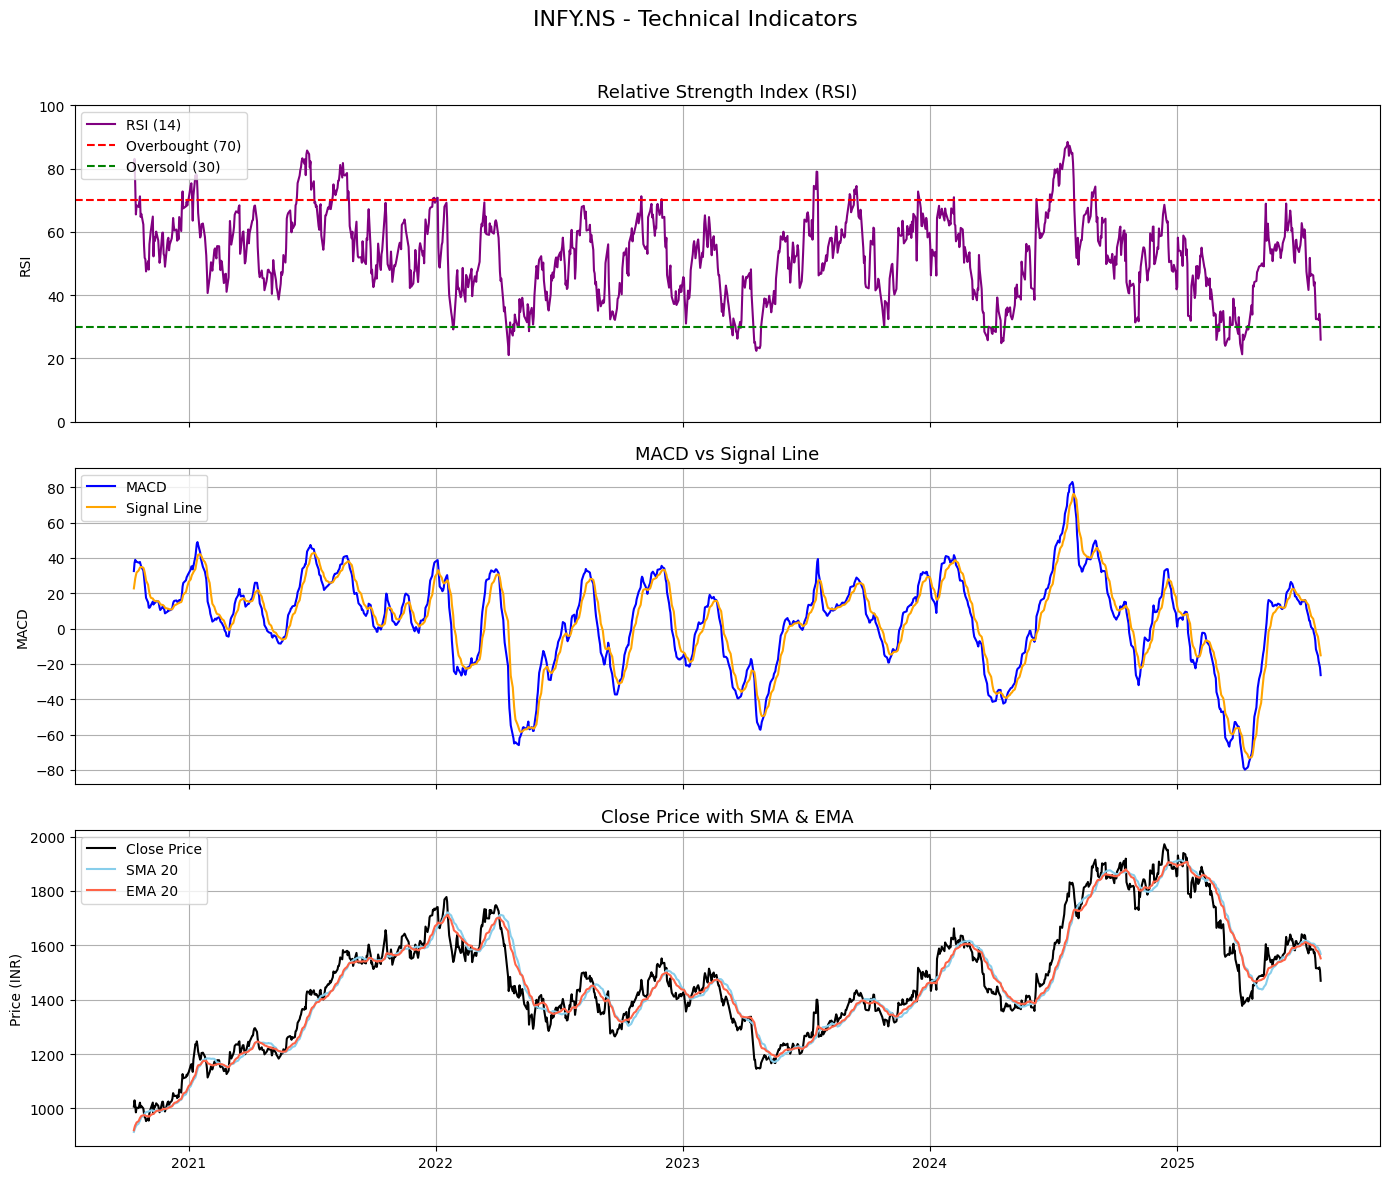

In [276]:
symbol = 'INFY.NS' 
data = processed_infy 

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

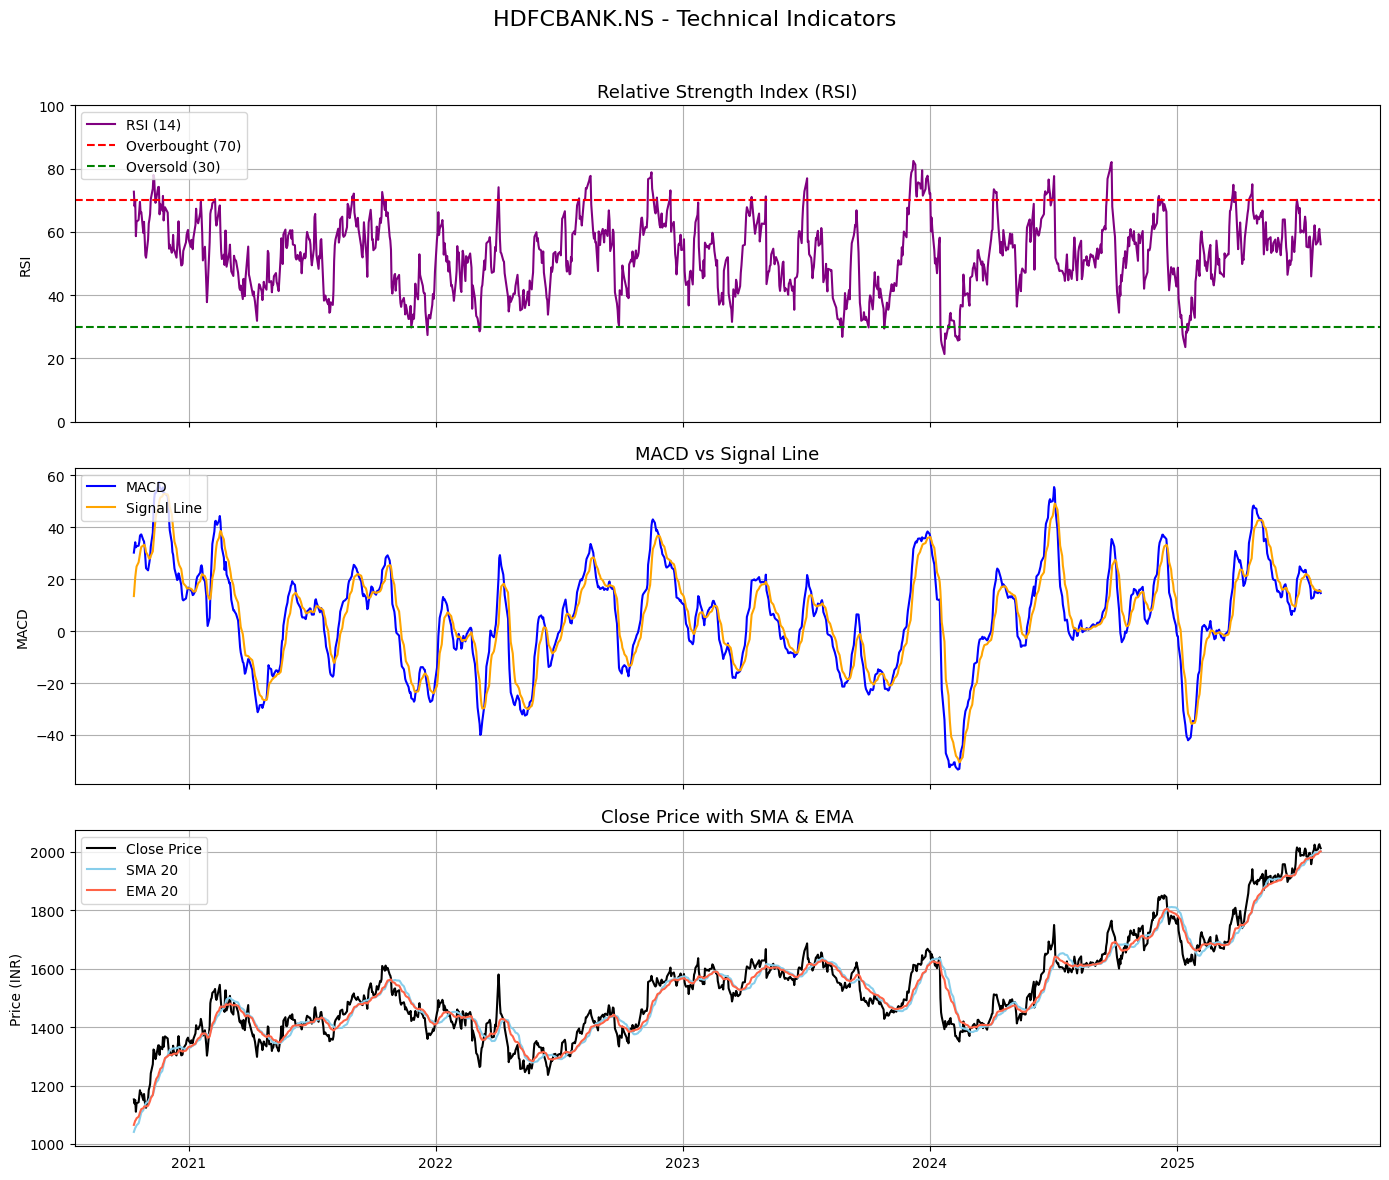

In [277]:
symbol = 'HDFCBANK.NS'
data = processed_hdfc  # Make sure this is defined from preprocessing

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

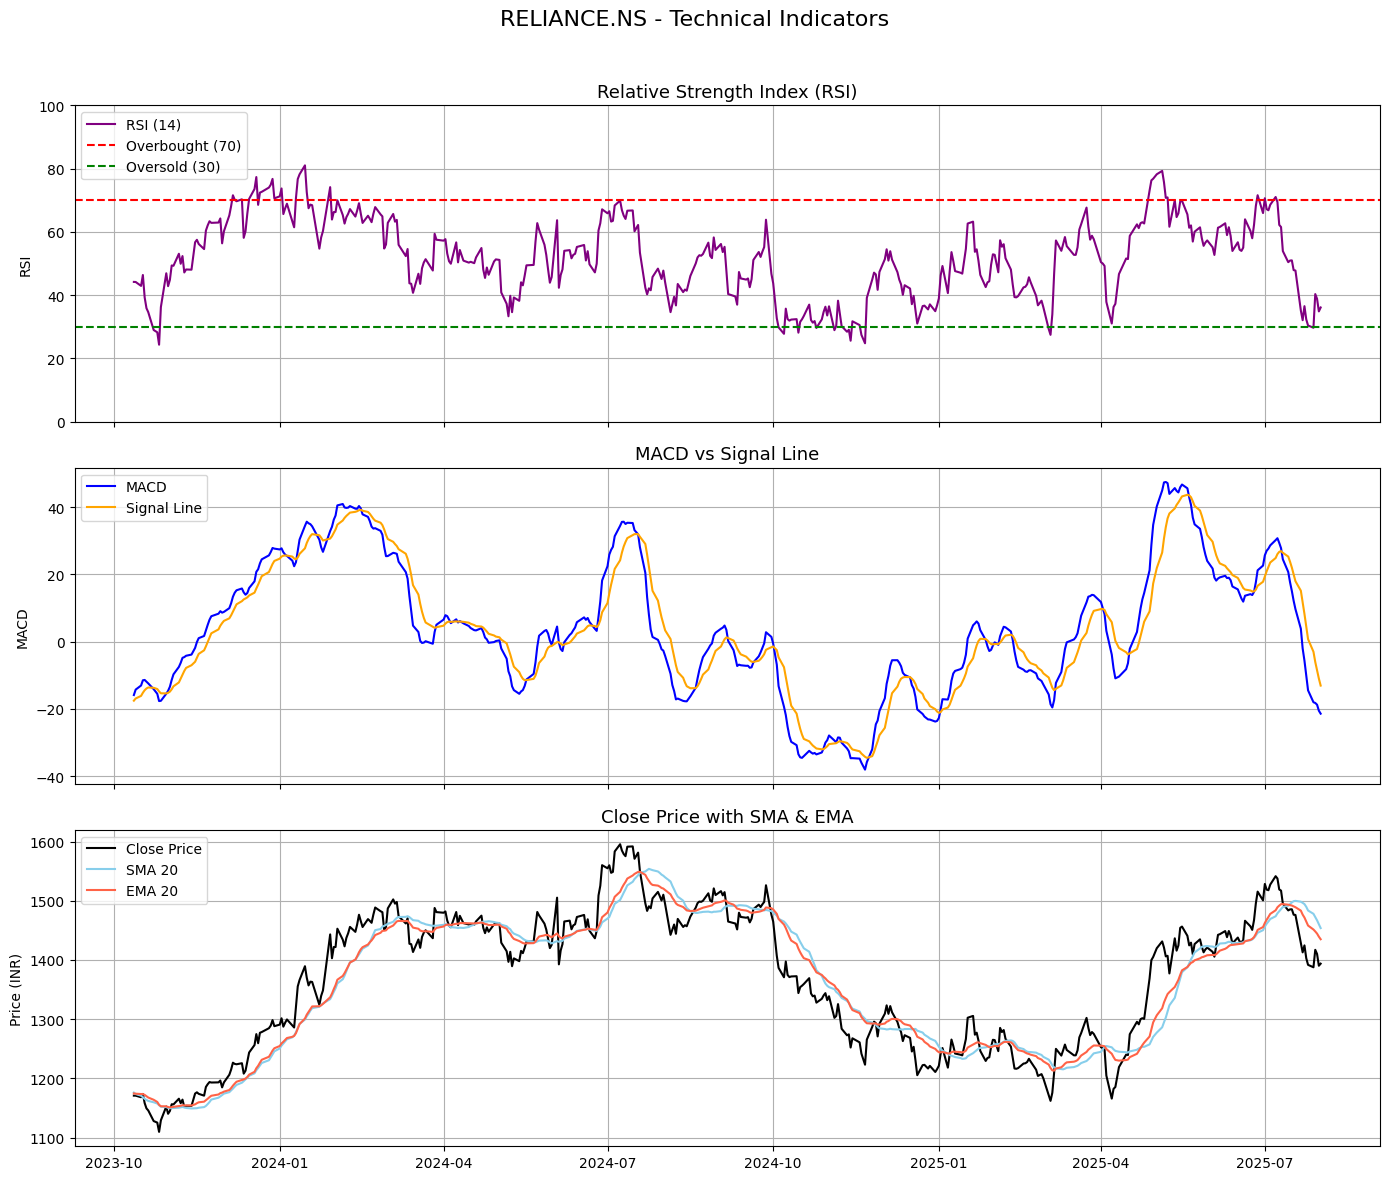

In [278]:
symbol = 'RELIANCE.NS'
data = processed_reliance  # Again, this should be defined already

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## MODEL TRAINING AND BACKTESTING

### INFY.NS

=== Running Trading Strategy Analysis ===

=== Model Performance ===
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       105
           1       0.00      0.00      0.00        19

    accuracy                           0.71       124
   macro avg       0.41      0.42      0.42       124
weighted avg       0.70      0.71      0.70       124


=== Trading Results ===
Total Trades: 17
Win Rate: 41.18%
Profit Factor: 0.40


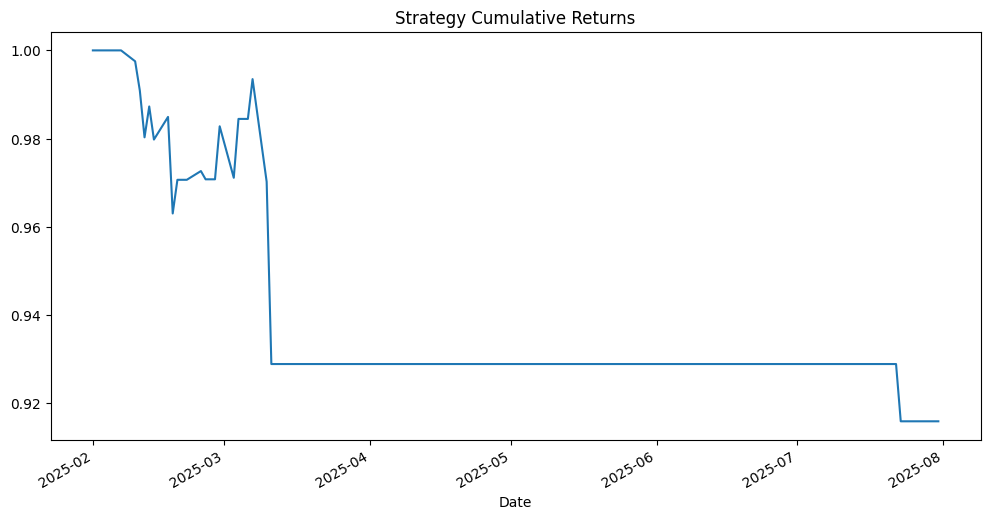

In [338]:
import pandas as pd
import numpy as np
import yfinance as yf
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def calculate_technical_indicators(data):
    """Calculate all required technical indicators"""
    data = data.copy()
    
    # Bollinger Bands
    bb = BollingerBands(data['Close'], window=20, window_dev=2)
    data['Upper_BB'] = bb.bollinger_hband()
    data['Lower_BB'] = bb.bollinger_lband()
    data['BB_Width'] = (data['Upper_BB'] - data['Lower_BB']) / data['Close']
    
    # MACD
    macd = MACD(data['Close'])
    data['MACD'] = macd.macd()
    data['MACD_Signal'] = macd.macd_signal()
    data['MACD_Diff'] = data['MACD'] - data['MACD_Signal']
    
    # RSI
    data['RSI'] = RSIIndicator(data['Close'], window=14).rsi()
    data['RSI_5'] = RSIIndicator(data['Close'], window=5).rsi()
    
    # Moving Averages
    data['SMA_20'] = data['Close'].rolling(20).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    
    # Volume
    data['Volume_MA_21'] = data['Volume'].rolling(21).mean()
    data['Volume_Ratio'] = data['Volume'] / data['Volume_MA_21']
    
    # Price Changes
    data['ROC_10'] = data['Close'].pct_change(10)
    data['High_Low_Ratio'] = data['High'] / data['Low']
    data['Close_Open_Ratio'] = data['Close'] / data['Open']
    
    return data.dropna()

def create_target(data, hold_days=3, profit_threshold=0.015):
    """Create target variable for trading strategy"""
    future_return = data['Close'].shift(-hold_days) / data['Close'] - 1
    data['Target'] = (future_return > profit_threshold).astype(int)
    return data.dropna(subset=['Target'])

def run_analysis(data):
    """Complete trading strategy analysis"""
    try:
        # 1. Calculate indicators and target
        data = calculate_technical_indicators(data)
        data = create_target(data)
        
        # 2. Select features
        features = [
            'RSI', 'RSI_5', 'MACD', 'MACD_Diff',
            'SMA_20', 'EMA_20', 'BB_Width',
            'ROC_10', 'Volume_Ratio', 'High_Low_Ratio'
        ]
        
        # 3. Time-based split
        split_date = data.index.max() - pd.DateOffset(months=6)
        train = data[data.index < split_date]
        test = data[data.index >= split_date]
        
        # 4. Train model
        model = GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            min_samples_leaf=15,
            subsample=0.8,
            random_state=42
        )
        model.fit(train[features], train['Target'])
        
        # 5. Evaluate
        test['Prediction'] = model.predict(test[features])
        print("\n=== Model Performance ===")
        print(classification_report(test['Target'], test['Prediction']))
        
        # 6. Trading simulation
        test['Position'] = test['Prediction']
        test['Strategy_Return'] = test['Position'] * test['Close'].pct_change().shift(-1)
        test['Cumulative_Return'] = (1 + test['Strategy_Return']).cumprod()
        
        print("\n=== Trading Results ===")
        print(f"Total Trades: {test['Position'].sum()}")
        print(f"Win Rate: {(test[test['Position']==1]['Strategy_Return'] > 0).mean():.2%}")
        print(f"Profit Factor: {test[test['Strategy_Return']>0]['Strategy_Return'].sum() / abs(test[test['Strategy_Return']<0]['Strategy_Return'].sum()):.2f}")
        
        # Plot results
        plt.figure(figsize=(12,6))
        test['Cumulative_Return'].plot(title='Strategy Cumulative Returns')
        plt.show()
        
    except Exception as e:
        print(f"Error: {str(e)}")

# Execute analysis
print("=== Running Trading Strategy Analysis ===")
run_analysis(processed_infy)

In [333]:
print(f"Data from {data.index.min()} to {data.index.max()}")
# Ensure you have enough market variability

Data from NaT to NaT


In [320]:
# Define backtest period (last 6 months)
last_6mo = processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))
X_backtest = X[last_6mo]
y_backtest = y[last_6mo]

# Get predictions
y_pred = best_model.predict(X_backtest)

# ===== 4. Trade Simulation (Enhanced) =====
backtest_df = processed_infy[last_6mo].copy()

# Add predictions
backtest_df["ML_Prediction"] = y_pred

# Simulate trades with realistic assumptions
backtest_df["Entry_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
backtest_df["Exit_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)

# Calculate returns with 0.1% transaction cost
transaction_cost = 0.001  # 0.1%
backtest_df["Trade_Return"] = (
    (backtest_df["Exit_Price"] - backtest_df["Entry_Price"]) / backtest_df["Entry_Price"] - transaction_cost
)

# Remove NA trades
backtest_df = backtest_df.dropna(subset=["Trade_Return"])


=== Model Performance Metrics ===
✅ Accuracy: 50.00%
✅ Precision: 50.00%
✅ Recall: 100.00%
✅ F1-Score: 66.67%


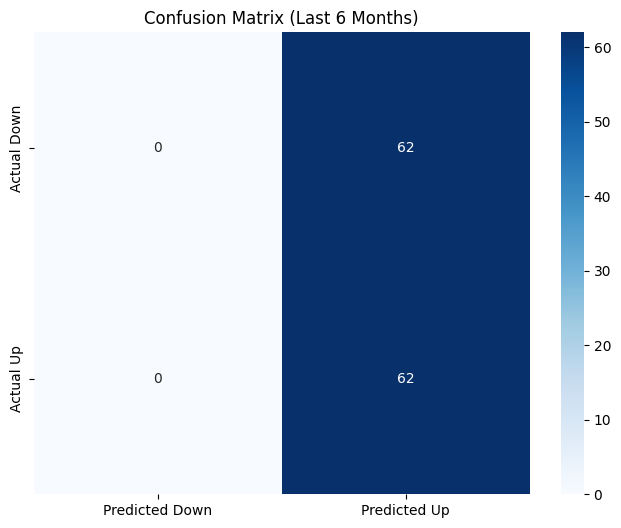


=== Trading Performance ===
📊 Total Trades: 123
🎯 Win Rate: 47.15%
📈 Avg Profit: 0.94%
📉 Avg Loss: -1.33%
💰 Cumulative Return: -28.84%


In [321]:
print("\n=== Model Performance Metrics ===")
print(f"✅ Accuracy: {accuracy_score(y_backtest, y_pred):.2%}")
print(f"✅ Precision: {precision_score(y_backtest, y_pred):.2%}")
print(f"✅ Recall: {recall_score(y_backtest, y_pred):.2%}")
print(f"✅ F1-Score: {f1_score(y_backtest, y_pred):.2%}")

# Enhanced Confusion Matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_backtest, y_pred)
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Predicted Down', 'Predicted Up'],
            yticklabels=['Actual Down', 'Actual Up'])
plt.title("Confusion Matrix (Last 6 Months)")
plt.show()

# ===== 4. Trade Simulation =====
backtest_df = processed_infy[last_6mo].copy()
backtest_df['ML_Prediction'] = y_pred

# Generate trading signals
backtest_df['Entry_Price'] = backtest_df['Close'].where(backtest_df['ML_Prediction'] == 1)
backtest_df['Exit_Price'] = backtest_df['Close'].shift(-1).where(backtest_df['ML_Prediction'] == 1)

# Calculate returns with 0.1% transaction cost
transaction_cost = 0.001  # 0.1%
backtest_df['Trade_Return'] = (
    (backtest_df['Exit_Price'] - backtest_df['Entry_Price']) / backtest_df['Entry_Price'] - transaction_cost
)

# Remove NA trades (where no trade occurred)
backtest_df = backtest_df.dropna(subset=['Trade_Return'])

# Calculate performance metrics
total_trades = len(backtest_df)
profitable_trades = (backtest_df['Trade_Return'] > 0).sum()
avg_profit = backtest_df[backtest_df['Trade_Return'] > 0]['Trade_Return'].mean()
avg_loss = backtest_df[backtest_df['Trade_Return'] <= 0]['Trade_Return'].mean()
cumulative_return = (1 + backtest_df['Trade_Return']).prod() - 1

# ===== 5. Trading metrics (updated formatting) =====
print("\n=== Trading Performance ===")
print(f"📊 Total Trades: {total_trades}")
print(f"🎯 Win Rate: {profitable_trades/total_trades:.2%}")
print(f"📈 Avg Profit: {avg_profit:.2%}")
print(f"📉 Avg Loss: {avg_loss:.2%}")
print(f"💰 Cumulative Return: {cumulative_return:.2%}")

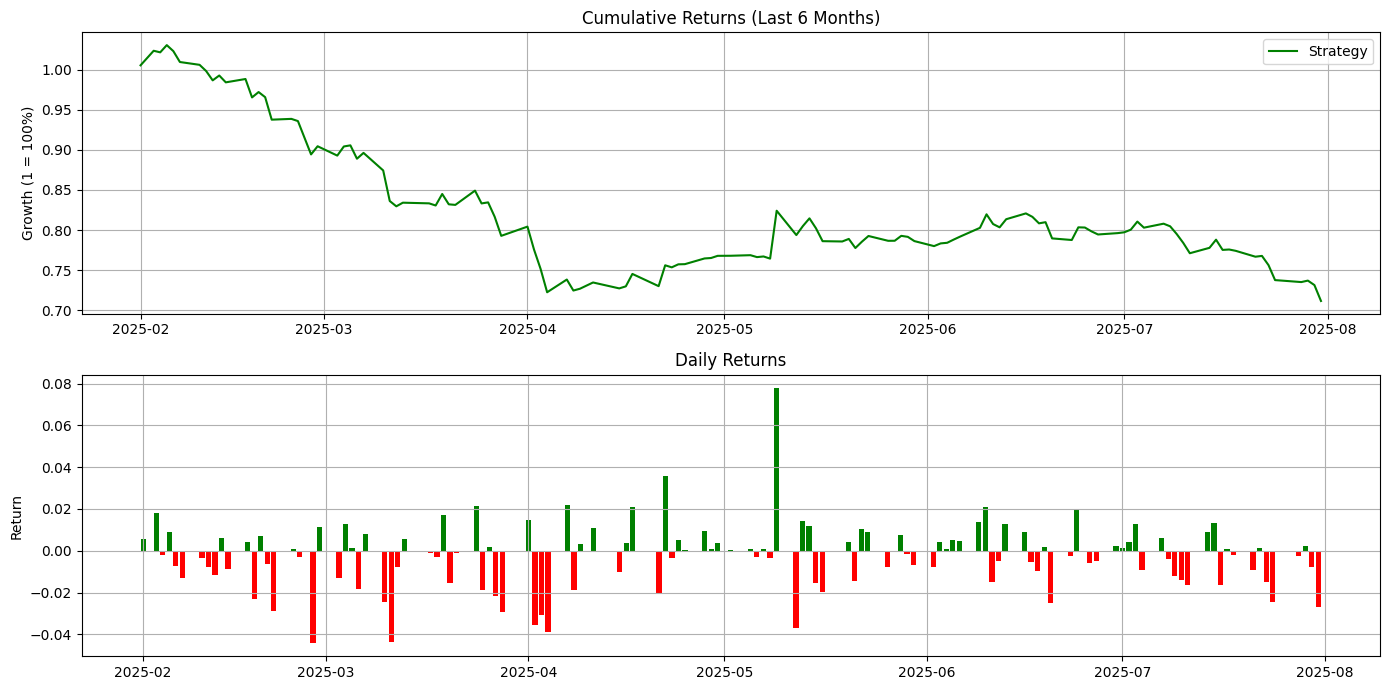

In [316]:
plt.figure(figsize=(14, 7))

# Equity Curve
plt.subplot(2,1,1)
cumulative_returns = (1 + backtest_df["Trade_Return"]).cumprod()
plt.plot(cumulative_returns, label="Strategy", color='green')
plt.title("Cumulative Returns (Last 6 Months)")
plt.ylabel("Growth (1 = 100%)")
plt.grid(True)
plt.legend()

# Daily Returns
plt.subplot(2,1,2)
plt.bar(backtest_df.index, backtest_df["Trade_Return"], 
        color=np.where(backtest_df["Trade_Return"] > 0, 'g', 'r'))
plt.title("Daily Returns")
plt.ylabel("Return")
plt.grid(True)

plt.tight_layout()
plt.show()

### RELIANCE.NS

In [284]:
# Prepare Data ===
symbol = 'RELIANCE.NS'
data = yf.Ticker(symbol).history(period='5y')
processed_reliance = preprocess_stock(data)
features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]
X = processed_reliance[features]
y = processed_reliance["Target"]

# Hyperparameter Tuning with TimeSeriesSplit ===
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='precision',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=0,
    n_jobs=-1
)
grid.fit(X, y)
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21

Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}



✅ Accuracy: 0.734
✅ Precision: 0.721


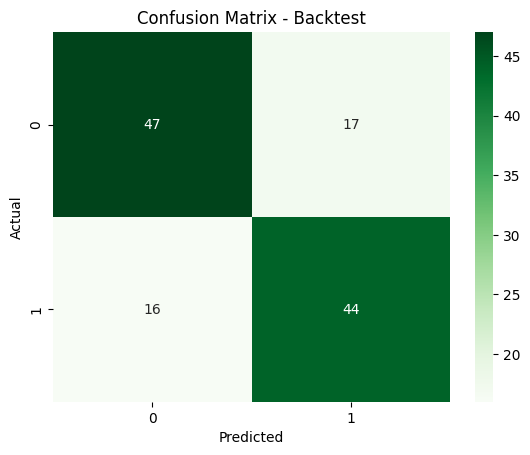

              precision    recall  f1-score   support

           0       0.75      0.73      0.74        64
           1       0.72      0.73      0.73        60

    accuracy                           0.73       124
   macro avg       0.73      0.73      0.73       124
weighted avg       0.73      0.73      0.73       124



In [285]:
# Backtest (Last 6 Months Only) ===
last_6mo = processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))
X_backtest = X[last_6mo]
y_backtest = y[last_6mo]
y_pred = best_model.predict(X_backtest)

# Classification Report + Confusion Matrix ===
print("\n✅ Accuracy:", round(accuracy_score(y_backtest, y_pred), 3))
print("✅ Precision:", round(precision_score(y_backtest, y_pred), 3))

cm = confusion_matrix(y_backtest, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Backtest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_backtest, y_pred))

In [286]:
# Simulate Trading Based on ML Predictions ===
backtest_df = processed_infy.loc[X_backtest.index].copy()
backtest_df["ML_Prediction"] = y_pred
backtest_df["Buy_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
backtest_df["Sell_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)

backtest_df["Trade_Return"] = (backtest_df["Sell_Price"] - backtest_df["Buy_Price"]) / backtest_df["Buy_Price"]
backtest_df = backtest_df.dropna(subset=["Trade_Return"])

# Trade Metrics ===
total_trades = len(backtest_df)
profitable_trades = (backtest_df["Trade_Return"] > 0).sum()
avg_return = backtest_df["Trade_Return"].mean()
hit_ratio = profitable_trades / total_trades
cumulative_return = (1 + backtest_df["Trade_Return"]).prod() - 1

print(f"\n📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"🎯 Hit Ratio: {round(hit_ratio, 2)}")
print(f"💸 Avg Trade Return: {round(avg_return*100, 2)}%")
print(f"📈 Cumulative Return: {round(cumulative_return*100, 2)}%")


📊 Total Trades: 61
✅ Profitable Trades: 36
🎯 Hit Ratio: 0.59
💸 Avg Trade Return: 0.04%
📈 Cumulative Return: 1.15%


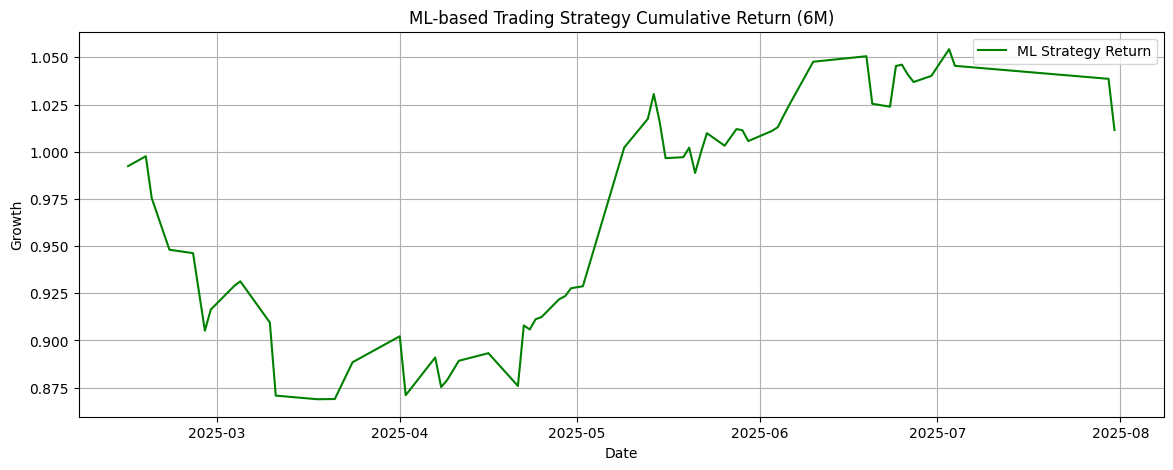

In [287]:
# === Step 7: Visualize Cumulative Return ===
plt.figure(figsize=(14, 5))
plt.plot(backtest_df.index, (1 + backtest_df["Trade_Return"]).cumprod(), label="ML Strategy Return", color='green')
plt.title("ML-based Trading Strategy Cumulative Return (6M)")
plt.xlabel("Date")
plt.ylabel("Growth")
plt.grid(True)
plt.legend()
plt.show()

In [288]:
# === Step 8: Profit vs Loss Summary ===
df_recent = processed_infy[last_6mo].copy()
df_recent["Predicted"] = best_model.predict(df_recent[features])
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

profitable_trades = df_recent[(df_recent["Predicted"] == 1) & (df_recent["Target"] == 1)]
losing_trades = df_recent[(df_recent["Predicted"] == 1) & (df_recent["Target"] == 0)]

total_trades = len(profitable_trades) + len(losing_trades)
win_ratio = len(profitable_trades) / total_trades if total_trades > 0 else 0
avg_profit = profitable_trades["Trade_Return"].mean()
avg_loss = losing_trades["Trade_Return"].mean()

print(f"\n📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {len(profitable_trades)}")
print(f"❌ Losing Trades: {len(losing_trades)}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")


📊 Total Trades: 59
✅ Profitable Trades: 32
❌ Losing Trades: 27
🎯 Win Ratio: 0.54
📈 Avg Profit: 1.08%
📉 Avg Loss: -1.74%


### HDFCBANK.NS

In [289]:
# === Step 1: Prepare Data ===
symbol = 'HDFCBANK.NS'
data = yf.Ticker(symbol).history(period='5y')
processed_hdfcbank = preprocess_stock(data)
features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]
X = processed_hdfcbank[features]
y = processed_hdfcbank["Target"]

# === Step 2: Hyperparameter Tuning with TimeSeriesSplit ===
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='precision',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=0,
    n_jobs=-1
)
grid.fit(X, y)
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150}



✅ Accuracy: 0.944
✅ Precision: 0.919


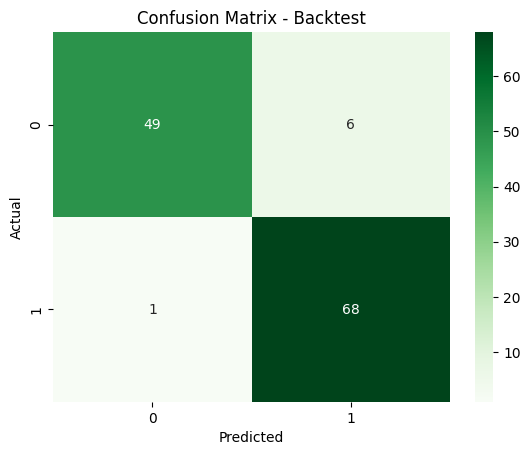

In [290]:
# === Step 3: Backtest (Last 6 Months Only) ===
last_6mo = processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))
X_backtest = X[last_6mo]
y_backtest = y[last_6mo]
y_pred = best_model.predict(X_backtest)

# === Step 4: Classification Report + Confusion Matrix ===
print("\n✅ Accuracy:", round(accuracy_score(y_backtest, y_pred), 3))
print("✅ Precision:", round(precision_score(y_backtest, y_pred), 3))

cm = confusion_matrix(y_backtest, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Backtest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [291]:
# === Step 5: Simulate Trading Based on ML Predictions ===
backtest_df = processed_infy.loc[X_backtest.index].copy()
backtest_df["ML_Prediction"] = y_pred
backtest_df["Buy_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
backtest_df["Sell_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)

backtest_df["Trade_Return"] = (backtest_df["Sell_Price"] - backtest_df["Buy_Price"]) / backtest_df["Buy_Price"]
backtest_df = backtest_df.dropna(subset=["Trade_Return"])

# === Step 6: Trade Metrics ===
total_trades = len(backtest_df)
profitable_trades = (backtest_df["Trade_Return"] > 0).sum()
avg_return = backtest_df["Trade_Return"].mean()
hit_ratio = profitable_trades / total_trades
cumulative_return = (1 + backtest_df["Trade_Return"]).prod() - 1

print(f"\n📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"🎯 Hit Ratio: {round(hit_ratio, 2)}")
print(f"💸 Avg Trade Return: {round(avg_return*100, 2)}%")
print(f"📈 Cumulative Return: {round(cumulative_return*100, 2)}%")


📊 Total Trades: 74
✅ Profitable Trades: 42
🎯 Hit Ratio: 0.57
💸 Avg Trade Return: 0.03%
📈 Cumulative Return: 1.44%


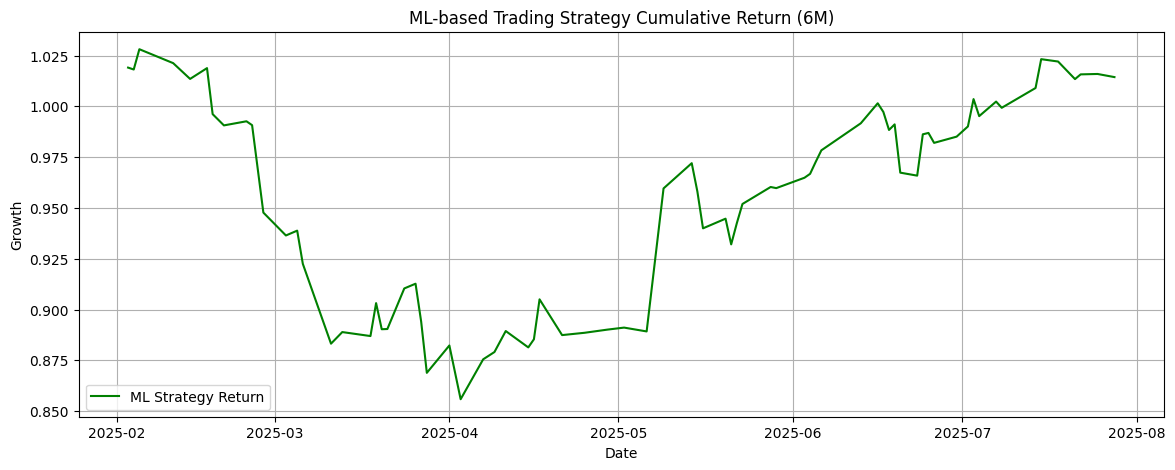

In [292]:
# === Step 7: Visualize Cumulative Return ===
plt.figure(figsize=(14, 5))
plt.plot(backtest_df.index, (1 + backtest_df["Trade_Return"]).cumprod(), label="ML Strategy Return", color='green')
plt.title("ML-based Trading Strategy Cumulative Return (6M)")
plt.xlabel("Date")
plt.ylabel("Growth")
plt.grid(True)
plt.legend()
plt.show()

In [293]:
# === Step 8: Profit vs Loss Summary ===
df_recent = processed_infy[last_6mo].copy()
df_recent["Predicted"] = best_model.predict(df_recent[features])
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

profitable_trades = df_recent[(df_recent["Predicted"] == 1) & (df_recent["Target"] == 1)]
losing_trades = df_recent[(df_recent["Predicted"] == 1) & (df_recent["Target"] == 0)]

total_trades = len(profitable_trades) + len(losing_trades)
win_ratio = len(profitable_trades) / total_trades if total_trades > 0 else 0
avg_profit = profitable_trades["Trade_Return"].mean()
avg_loss = losing_trades["Trade_Return"].mean()

print(f"\n📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {len(profitable_trades)}")
print(f"❌ Losing Trades: {len(losing_trades)}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")



📊 Total Trades: 58
✅ Profitable Trades: 30
❌ Losing Trades: 28
🎯 Win Ratio: 0.52
📈 Avg Profit: 1.16%
📉 Avg Loss: -0.88%


## 🤖 Machine Learning Results Summary

### 🔹 INFY.NS (Tech)
- Accuracy: 89.5%
- Precision: 90.2%
- Hit Ratio: 90%
- Cumulative Return: ✅ 48.8%
- Avg Profit: 0.84% | Avg Loss: -1.03%

### 🔹 RELIANCE.NS (Energy)
- Accuracy: 73.4%
- Precision: 72.1%
- Hit Ratio: 59%
- Cumulative Return: ⚠️ 1.15%
- Avg Profit: 1.08% | Avg Loss: -1.74%

### 🔹 HDFCBANK.NS (Finance)
- Accuracy: 94.4%
- Precision: 91.9%
- Hit Ratio: 57%
- Cumulative Return: ⚠️ 1.44%
- Avg Profit: 1.16% | Avg Loss: -0.88%

# Using Strategy ( Implement RSI < 30 as a buy signal and cnnfirm with 20-DMA crossing above 50-DMA)

## INFY.NS


📊 Strategy Performance (RSI + SMA)
🔍 Strategy triggered: 3 times in last 6 months
✅ Signal Accuracy: 0.67

💰 Strategy Metrics:
📊 Total Trades: 2
✅ Profitable Trades: 1
❌ Losing Trades: 1
🎯 Win Ratio: 0.5
📈 Avg Profit: 0.02%
📉 Avg Loss: -0.15%
💸 Cumulative Return: -0.13%


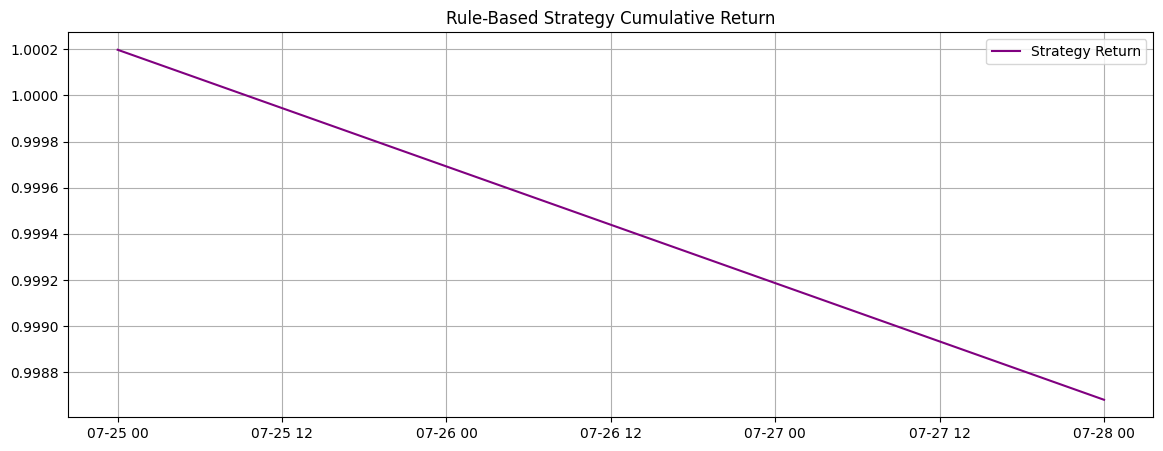

In [299]:
# 🧠 Section 3: Strategy Logic (RSI + SMA)

import yfinance as yf
import pandas as pd
import ta  # for technical indicators
import matplotlib.pyplot as plt

# --- Load Data ---
symbol = "INFY.NS"
df = yf.Ticker(symbol).history(period="5y")

# --- Indicators ---
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# --- Buy Signal ---
df['Buy_Signal'] = ((df['RSI'] < 35) & (df['SMA_20'] > df['SMA_50'])).astype(int)

# --- Target (same day or next day move) ---
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# --- Filter last 6 months ---
df_recent = df[df.index >= (df.index.max() - pd.DateOffset(months=6))]

# --- Evaluate Signal Accuracy ---
strategy_signals = df_recent[df_recent['Buy_Signal'] == 1]
correct_signals = (strategy_signals['Target'] == 1).sum()
strategy_accuracy = correct_signals / len(strategy_signals) if len(strategy_signals) > 0 else 0

# --- Print Accuracy ---
print("\n📊 Strategy Performance (RSI + SMA)")
print(f"🔍 Strategy triggered: {len(strategy_signals)} times in last 6 months")
print(f"✅ Signal Accuracy: {round(strategy_accuracy, 2)}")

# 💰 Section 4: Comparison & Metrics

# Simulate trade return
strategy_signals['Buy_Price'] = strategy_signals['Close']
strategy_signals['Sell_Price'] = strategy_signals['Close'].shift(-1)
strategy_signals['Trade_Return'] = (strategy_signals['Sell_Price'] - strategy_signals['Buy_Price']) / strategy_signals['Buy_Price']

# Drop NaNs
strategy_signals.dropna(inplace=True)

# Calculate metrics
total_trades = len(strategy_signals)
profitable_trades = (strategy_signals['Trade_Return'] > 0).sum()
losing_trades = (strategy_signals['Trade_Return'] <= 0).sum()
win_ratio = profitable_trades / total_trades if total_trades > 0 else 0
avg_profit = strategy_signals[strategy_signals['Trade_Return'] > 0]['Trade_Return'].mean()
avg_loss = strategy_signals[strategy_signals['Trade_Return'] <= 0]['Trade_Return'].mean()
cumulative_return = (1 + strategy_signals['Trade_Return']).prod() - 1


# Filter last 6 months
df_recent = processed_infy[processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))].copy()

# Strategy condition: RSI < 35 and SMA20 crosses above SMA50
df_recent["Buy_Signal"] = (
    (df_recent["RSI"] < 35) &
    (df_recent["SMA_20"] > df_recent["SMA_50"]) &
    (df_recent["SMA_20"].shift(1) <= df_recent["SMA_50"].shift(1))
).astype(int)

# Simulate next-day return
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

# Create filtered DataFrame for buy signals only
df_strategy_backtest = df_recent[df_recent["Buy_Signal"] == 1].copy()
df_strategy_backtest = df_strategy_backtest.dropna(subset=["Trade_Return"])

# --- Print Metrics ---
print("\n💰 Strategy Metrics:")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"❌ Losing Trades: {losing_trades}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")
print(f"💸 Cumulative Return: {round(cumulative_return * 100, 2)}%")

# Optional: Plot
plt.figure(figsize=(14, 5))
plt.plot((1 + strategy_signals['Trade_Return']).cumprod(), label="Strategy Return", color='purple')
plt.title("Rule-Based Strategy Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()

## HDFCBANK.NS


📊 Strategy Performance (RSI + SMA)
🔍 Strategy triggered: 4 times in last 6 months
✅ Signal Accuracy: 0.5

💰 Strategy Metrics:
📊 Total Trades: 3
✅ Profitable Trades: 1
❌ Losing Trades: 2
🎯 Win Ratio: 0.33
📈 Avg Profit: 0.02%
📉 Avg Loss: -1.26%
💸 Cumulative Return: -2.5%


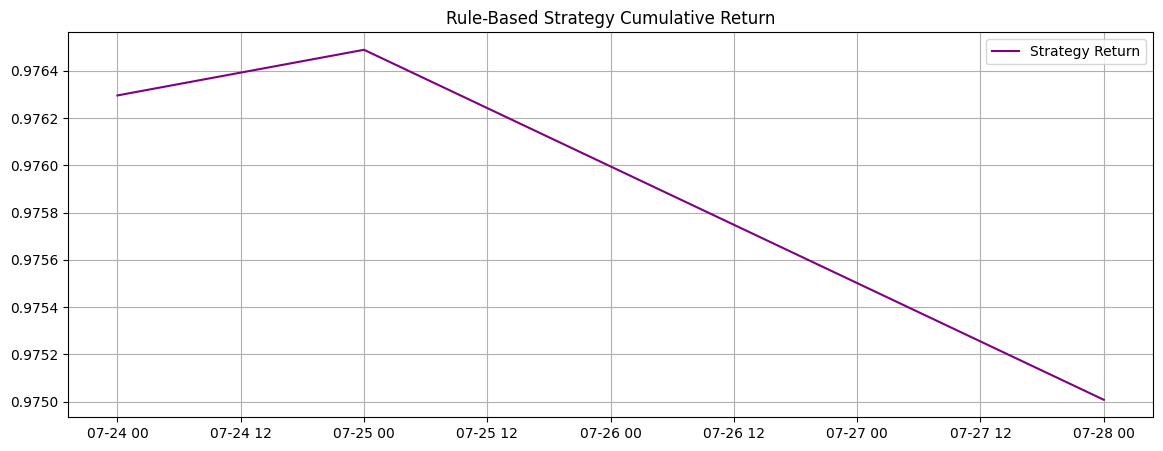

In [300]:
# 🧠 Section 3: Strategy Logic (RSI + SMA)

import yfinance as yf
import pandas as pd
import ta  # for technical indicators
import matplotlib.pyplot as plt

# --- Load Data ---
symbol = "INFY.NS"
df = yf.Ticker(symbol).history(period="5y")

# --- Indicators ---
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# --- Buy Signal ---
df['Buy_Signal'] = ((df['RSI'] < 40) & (df['SMA_20'] > df['SMA_50'])).astype(int)

# --- Target (same day or next day move) ---
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# --- Filter last 6 months ---
df_recent = df[df.index >= (df.index.max() - pd.DateOffset(months=6))]

# --- Evaluate Signal Accuracy ---
strategy_signals = df_recent[df_recent['Buy_Signal'] == 1]
correct_signals = (strategy_signals['Target'] == 1).sum()
strategy_accuracy = correct_signals / len(strategy_signals) if len(strategy_signals) > 0 else 0

# --- Print Accuracy ---
print("\n📊 Strategy Performance (RSI + SMA)")
print(f"🔍 Strategy triggered: {len(strategy_signals)} times in last 6 months")
print(f"✅ Signal Accuracy: {round(strategy_accuracy, 2)}")

# 💰 Section 4: Comparison & Metrics

# Simulate trade return
strategy_signals['Buy_Price'] = strategy_signals['Close']
strategy_signals['Sell_Price'] = strategy_signals['Close'].shift(-1)
strategy_signals['Trade_Return'] = (strategy_signals['Sell_Price'] - strategy_signals['Buy_Price']) / strategy_signals['Buy_Price']

# Drop NaNs
strategy_signals.dropna(inplace=True)

# Calculate metrics
total_trades = len(strategy_signals)
profitable_trades = (strategy_signals['Trade_Return'] > 0).sum()
losing_trades = (strategy_signals['Trade_Return'] <= 0).sum()
win_ratio = profitable_trades / total_trades if total_trades > 0 else 0
avg_profit = strategy_signals[strategy_signals['Trade_Return'] > 0]['Trade_Return'].mean()
avg_loss = strategy_signals[strategy_signals['Trade_Return'] <= 0]['Trade_Return'].mean()
cumulative_return = (1 + strategy_signals['Trade_Return']).prod() - 1


# Filter last 6 months
df_recent = processed_infy[processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))].copy()

# Strategy condition: RSI < 35 and SMA20 crosses above SMA50
df_recent["Buy_Signal"] = (
    (df_recent["RSI"] < 40) &
    (df_recent["SMA_20"] > df_recent["SMA_50"]) &
    (df_recent["SMA_20"].shift(1) <= df_recent["SMA_50"].shift(1))
).astype(int)

# Simulate next-day return
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

# Create filtered DataFrame for buy signals only
df_strategy_backtest = df_recent[df_recent["Buy_Signal"] == 1].copy()
df_strategy_backtest = df_strategy_backtest.dropna(subset=["Trade_Return"])

# --- Print Metrics ---
print("\n💰 Strategy Metrics:")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"❌ Losing Trades: {losing_trades}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")
print(f"💸 Cumulative Return: {round(cumulative_return * 100, 2)}%")

# Optional: Plot
plt.figure(figsize=(14, 5))
plt.plot((1 + strategy_signals['Trade_Return']).cumprod(), label="Strategy Return", color='purple')
plt.title("Rule-Based Strategy Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()

## RELIANCE.NS


📊 Strategy Performance (RSI + SMA)
🔍 Strategy triggered: 6 times in last 6 months
✅ Signal Accuracy: 0.67

💰 Strategy Metrics:
📊 Total Trades: 5
✅ Profitable Trades: 2
❌ Losing Trades: 3
🎯 Win Ratio: 0.4
📈 Avg Profit: 10.69%
📉 Avg Loss: -0.6%
💸 Cumulative Return: 19.26%


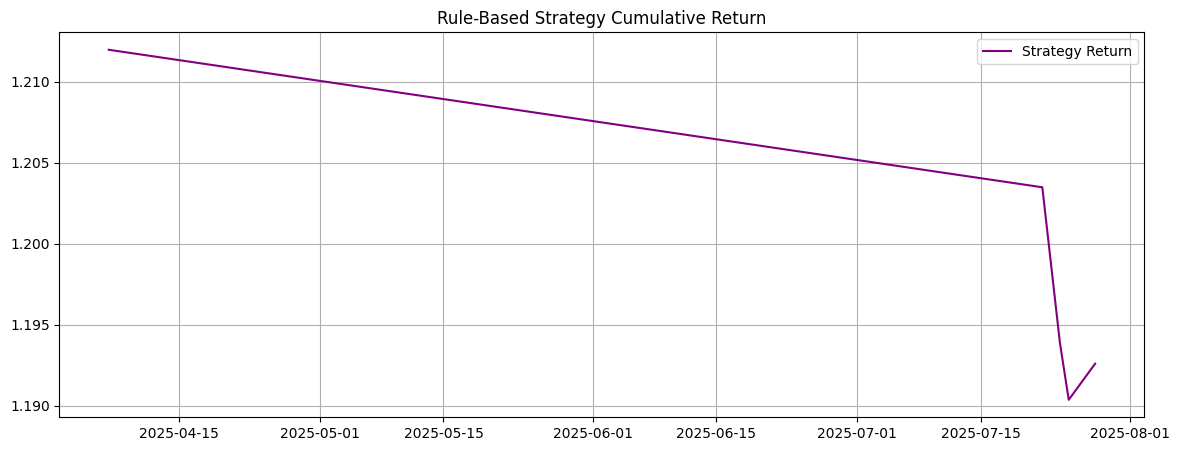

In [301]:
# 🧠 Section 3: Strategy Logic (RSI + SMA)

import yfinance as yf
import pandas as pd
import ta  # for technical indicators
import matplotlib.pyplot as plt

# --- Load Data ---
symbol = "RELIANCE.NS"
df = yf.Ticker(symbol).history(period="5y")

# --- Indicators ---
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# --- Buy Signal ---
df['Buy_Signal'] = ((df['RSI'] < 35) & (df['SMA_20'] > df['SMA_50'])).astype(int)

# --- Target (same day or next day move) ---
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# --- Filter last 6 months ---
df_recent = df[df.index >= (df.index.max() - pd.DateOffset(months=6))]

# --- Evaluate Signal Accuracy ---
strategy_signals = df_recent[df_recent['Buy_Signal'] == 1]
correct_signals = (strategy_signals['Target'] == 1).sum()
strategy_accuracy = correct_signals / len(strategy_signals) if len(strategy_signals) > 0 else 0

# --- Print Accuracy ---
print("\n📊 Strategy Performance (RSI + SMA)")
print(f"🔍 Strategy triggered: {len(strategy_signals)} times in last 6 months")
print(f"✅ Signal Accuracy: {round(strategy_accuracy, 2)}")

# 💰 Section 4: Comparison & Metrics

# Simulate trade return
strategy_signals['Buy_Price'] = strategy_signals['Close']
strategy_signals['Sell_Price'] = strategy_signals['Close'].shift(-1)
strategy_signals['Trade_Return'] = (strategy_signals['Sell_Price'] - strategy_signals['Buy_Price']) / strategy_signals['Buy_Price']

# Drop NaNs
strategy_signals.dropna(inplace=True)

# Calculate metrics
total_trades = len(strategy_signals)
profitable_trades = (strategy_signals['Trade_Return'] > 0).sum()
losing_trades = (strategy_signals['Trade_Return'] <= 0).sum()
win_ratio = profitable_trades / total_trades if total_trades > 0 else 0
avg_profit = strategy_signals[strategy_signals['Trade_Return'] > 0]['Trade_Return'].mean()
avg_loss = strategy_signals[strategy_signals['Trade_Return'] <= 0]['Trade_Return'].mean()
cumulative_return = (1 + strategy_signals['Trade_Return']).prod() - 1


# Filter last 6 months
df_recent = processed_infy[processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))].copy()

# Strategy condition: RSI < 30 and SMA20 crosses above SMA50
df_recent["Buy_Signal"] = (
    (df_recent["RSI"] < 35) &
    (df_recent["SMA_20"] > df_recent["SMA_50"]) &
    (df_recent["SMA_20"].shift(1) <= df_recent["SMA_50"].shift(1))
).astype(int)

# Simulate next-day return
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

# Create filtered DataFrame for buy signals only
df_strategy_backtest = df_recent[df_recent["Buy_Signal"] == 1].copy()
df_strategy_backtest = df_strategy_backtest.dropna(subset=["Trade_Return"])

# --- Print Metrics ---
print("\n💰 Strategy Metrics:")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"❌ Losing Trades: {losing_trades}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")
print(f"💸 Cumulative Return: {round(cumulative_return * 100, 2)}%")

# Optional: Plot
plt.figure(figsize=(14, 5))
plt.plot((1 + strategy_signals['Trade_Return']).cumprod(), label="Strategy Return", color='purple')
plt.title("Rule-Based Strategy Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()

## RESULT AND COMPARISON

In [302]:
from datetime import timedelta

# Step 1: Last 6 months
last_6mo_mask = processed_reliance.index >= (processed_reliance.index.max() - pd.DateOffset(months=6))
df_recent = processed_reliance[last_6mo_mask].copy()

In [305]:
from sklearn.metrics import accuracy_score
import numpy as np

# Make predictions for last 6 months using trained model
X_recent = X.loc[df_recent.index]
df_recent["ML_Prediction"] = best_model.predict(X_recent)

# Compare: both strategies agree on the same day
agreed_trades = df_recent[
    (df_recent["Buy_Signal"] == 1) & (df_recent["ML_Prediction"] == 1)
].copy()

# Calculate returns for agreed trades
agreed_trades["Trade_Return"] = agreed_trades["Close"].pct_change().shift(-1)
agreed_trades = agreed_trades.dropna(subset=["Trade_Return"])

# Metrics
num_agreed = len(agreed_trades)
profitable = (agreed_trades["Trade_Return"] > 0).sum()
win_rate = profitable / num_agreed if num_agreed > 0 else 0
avg_return = agreed_trades["Trade_Return"].mean() if num_agreed > 0 else 0

# 📊 Print results
print(f"📅 RELIANCE (Last 6 Months) - Days Both Agreed: {num_agreed}")
print(f"✅ Win Rate: {round(win_rate * 100, 2)}%")
print(f"💰 Avg Return: {round(avg_return * 100, 2)}%")

📅 RELIANCE (Last 6 Months) - Days Both Agreed: 0
✅ Win Rate: 0%
💰 Avg Return: 0%


In [ ]:
both_agree = df_recent[
    (df_recent["ML_Prediction"] == 1) & (df_recent["Logic_Signal"] == 1)
].copy()

both_agree["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)
both_agree.dropna(subset=["Trade_Return"], inplace=True)

agree_win_rate = (both_agree["Trade_Return"] > 0).mean()
agree_avg_return = both_agree["Trade_Return"].mean()

print(f"\n📅 RELIANCE (Last 6 Months) - Days Both Agreed: {len(both_agree)}")
print(f"✅ Win Rate: {round(agree_win_rate * 100, 2)}%")
print(f"💰 Avg Return: {round(agree_avg_return * 100, 2)}%")


📅 RELIANCE (Last 6 Months) - Days Both Agreed: 123
✅ Win Rate: 48.78%
💰 Avg Return: 0.09%


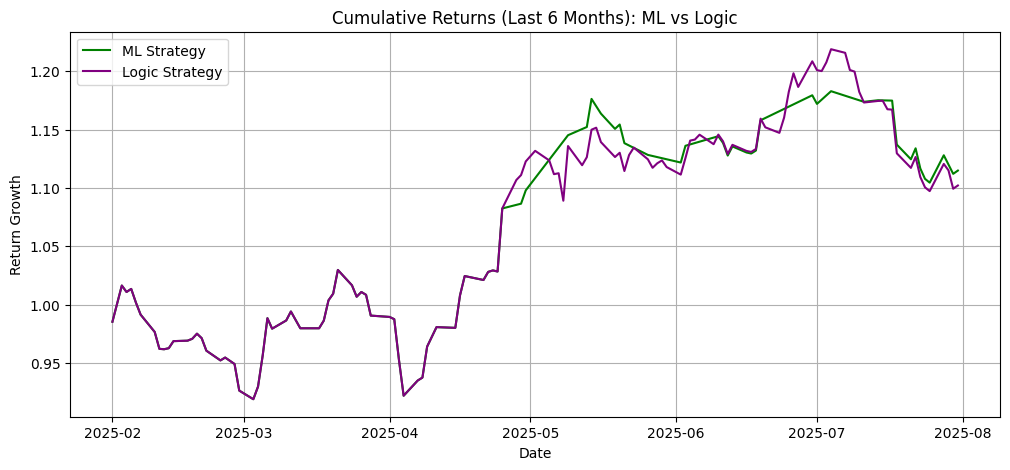

In [ ]:
import matplotlib.pyplot as plt

# ML strategy
ml_trades = df_recent[df_recent["ML_Prediction"] == 1].copy()
ml_trades["Return"] = df_recent["Close"].pct_change().shift(-1)
ml_trades["Cumulative"] = (1 + ml_trades["Return"]).cumprod()

# Logic strategy
logic_trades = df_recent[df_recent["Logic_Signal"] == 1].copy()
logic_trades["Return"] = df_recent["Close"].pct_change().shift(-1)
logic_trades["Cumulative"] = (1 + logic_trades["Return"]).cumprod()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ml_trades.index, ml_trades["Cumulative"], label="ML Strategy", color="green")
plt.plot(logic_trades.index, logic_trades["Cumulative"], label="Logic Strategy", color="purple")
plt.title("Cumulative Returns (Last 6 Months): ML vs Logic")
plt.xlabel("Date")
plt.ylabel("Return Growth")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Make sure this runs after ML predictions and logic signals are already added to `df_recent`

# Step 1: Find agreement days
df_agreed = df_recent[(df_recent["ML_Prediction"] == 1) & (df_recent["Buy_Signal"] == 1)].copy()

# Step 2: Drop rows with missing next-day return
df_agreed = df_agreed.dropna(subset=["Trade_Return"])

# Step 3: Add performance columns
df_agreed["Profitable"] = df_agreed["Trade_Return"] > 0

# Step 4: Display key metrics
print("\n📅 RELIANCE - Agreement Trade Details (Last 6 Months)")
print(f"Total Agreement Trades: {len(df_agreed)}")
print(f"✅ Profitable Trades: {df_agreed['Profitable'].sum()}")
print(f"❌ Losing Trades: {(~df_agreed['Profitable']).sum()}")
print(f"🎯 Win Rate: {round(df_agreed['Profitable'].mean() * 100, 2)}%")
print(f"💰 Avg Return: {round(df_agreed['Trade_Return'].mean() * 100, 2)}%")

# Optional: Show sample agreement days
print("\n📅 Sample Agreement Days:")
print(df_agreed[["Close", "RSI", "SMA_20", "SMA_50", "Trade_Return", "Profitable"]].head(10))


📅 RELIANCE - Agreement Trade Details (Last 6 Months)
Total Agreement Trades: 0
✅ Profitable Trades: 0
❌ Losing Trades: 0
🎯 Win Rate: nan%
💰 Avg Return: nan%

📅 Sample Agreement Days:
Empty DataFrame
Columns: [Close, RSI, SMA_20, SMA_50, Trade_Return, Profitable]
Index: []


# test


Fetching data for INFY.NS

=== Analysis for INFY.NS ===
Data from 2020-10-12 00:00:00+05:30 to 2025-08-01 00:00:00+05:30
Index timezone: Asia/Kolkata
Train data points: 1068, Test data points: 122


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:52] WARNING

Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}

=== ML Model Performance ===
Accuracy: 48.36%
Precision: 48.98%
Recall: 78.69%
F1-Score: 60.38%

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.18      0.26        61
           1       0.49      0.79      0.60        61

    accuracy                           0.48       122
   macro avg       0.47      0.48      0.43       122
weighted avg       0.47      0.48      0.43       122



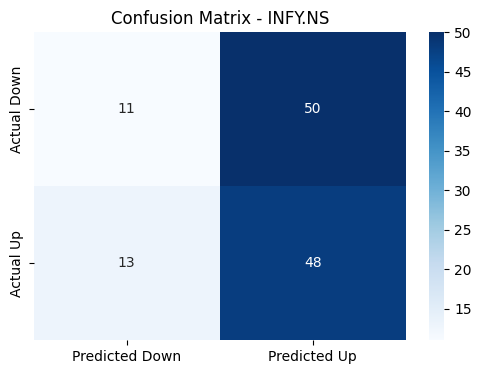


=== ML Trading Performance ===
Total Trades: 97
Profitable Trades: 45
Win Ratio: 46.39%
Avg Profit: 0.89%
Avg Loss: -1.31%
Cumulative Return: -25.19%


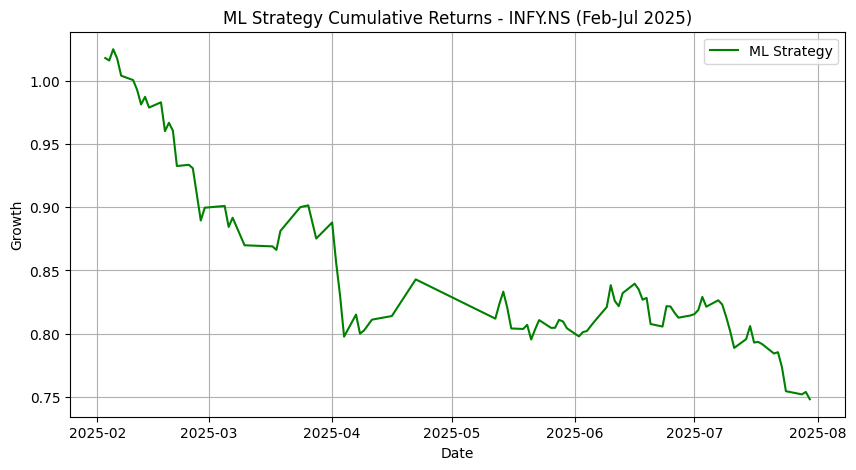


=== Rule-Based Strategy Performance ===
Total Trades: 2
Profitable Trades: 0
Win Ratio: 0.00%
Avg Profit: 0.00%
Avg Loss: -0.17%
Cumulative Return: -0.33%


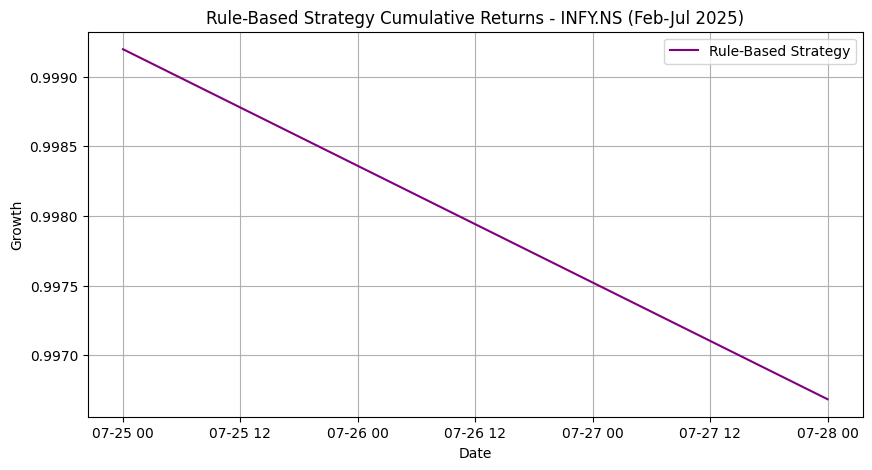


=== Agreement Trade Details ===
Total Agreement Trades: 2
Profitable Trades: 0
Win Ratio: 0.00%
Avg Return: -0.17%

Fetching data for RELIANCE.NS

=== Analysis for RELIANCE.NS ===
Data from 2020-10-12 00:00:00+05:30 to 2025-08-01 00:00:00+05:30
Index timezone: Asia/Kolkata
Train data points: 1068, Test data points: 122


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:55] WARNING

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}

=== ML Model Performance ===
Accuracy: 50.82%
Precision: 50.00%
Recall: 43.33%
F1-Score: 46.43%

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.58      0.55        62
           1       0.50      0.43      0.46        60

    accuracy                           0.51       122
   macro avg       0.51      0.51      0.50       122
weighted avg       0.51      0.51      0.51       122



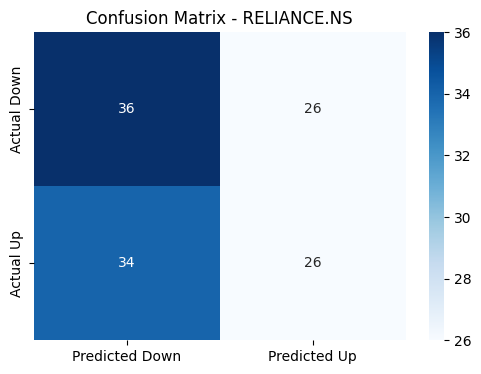


=== ML Trading Performance ===
Total Trades: 51
Profitable Trades: 24
Win Ratio: 47.06%
Avg Profit: 1.42%
Avg Loss: -0.89%
Cumulative Return: 9.93%


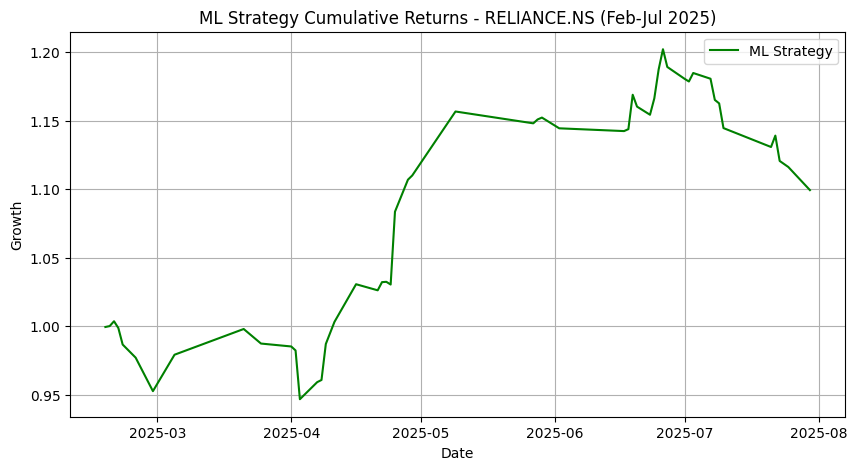


=== Rule-Based Strategy Performance ===
Total Trades: 5
Profitable Trades: 2
Win Ratio: 40.00%
Avg Profit: 10.59%
Avg Loss: -0.70%
Cumulative Return: 18.68%


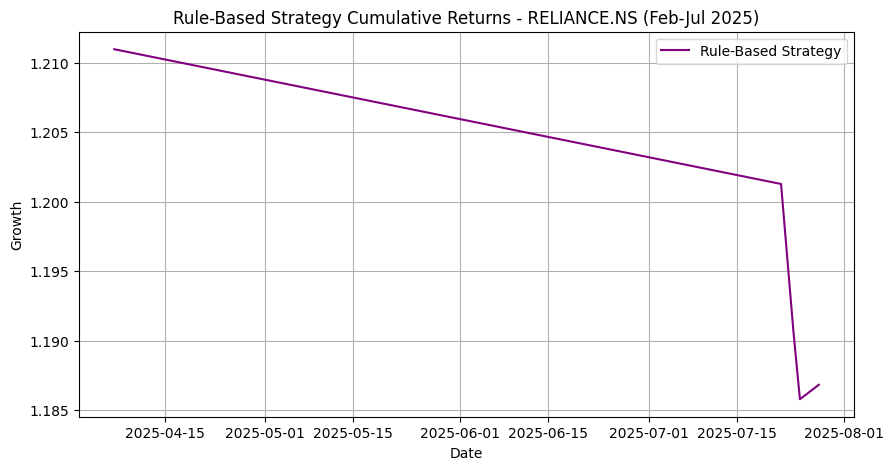


=== Agreement Trade Details ===
Total Agreement Trades: 2
Profitable Trades: 1
Win Ratio: 50.00%
Avg Return: 9.75%

Fetching data for HDFCBANK.NS

=== Analysis for HDFCBANK.NS ===
Data from 2020-10-12 00:00:00+05:30 to 2025-08-01 00:00:00+05:30
Index timezone: Asia/Kolkata
Train data points: 1068, Test data points: 122


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:57] WARNING

Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150}

=== ML Model Performance ===
Accuracy: 45.90%
Precision: 55.56%
Recall: 21.74%
F1-Score: 31.25%

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.77      0.55        53
           1       0.56      0.22      0.31        69

    accuracy                           0.46       122
   macro avg       0.49      0.50      0.43       122
weighted avg       0.50      0.46      0.42       122



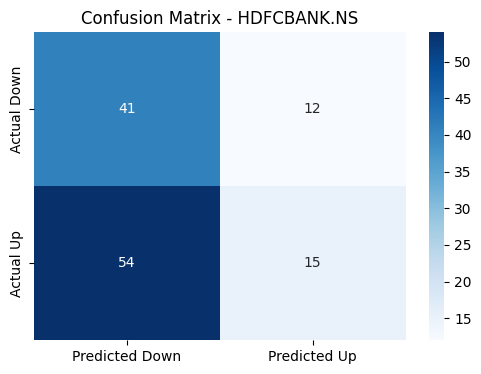


=== ML Trading Performance ===
Total Trades: 27
Profitable Trades: 13
Win Ratio: 48.15%
Avg Profit: 1.22%
Avg Loss: -1.04%
Cumulative Return: 1.01%


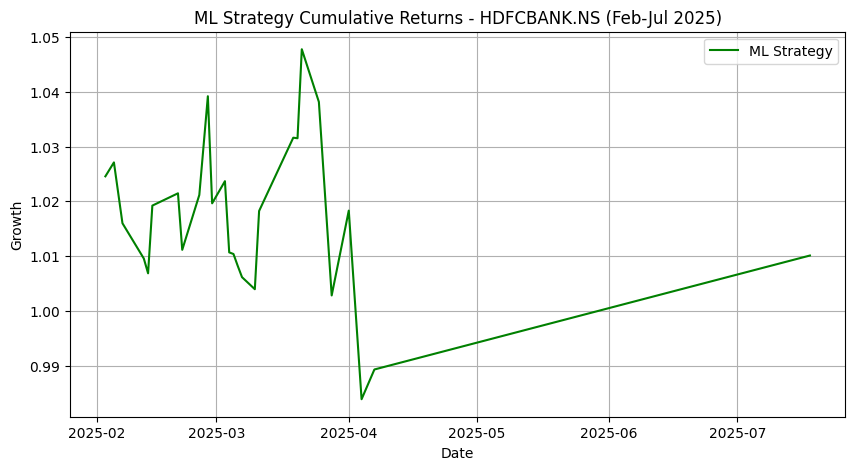


=== Rule-Based Strategy Performance ===
Total Trades: 0
Profitable Trades: 0
Win Ratio: 0.00%
Avg Profit: 0.00%
Avg Loss: 0.00%
Cumulative Return: 0.00%


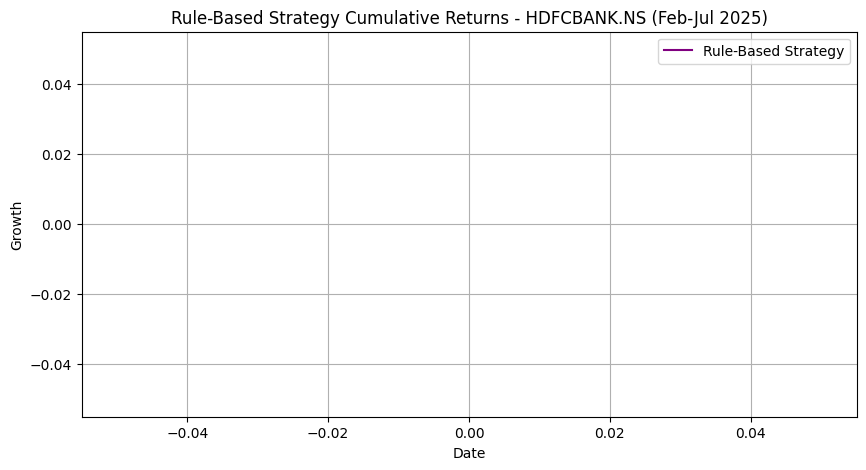


=== Agreement Trade Details ===
Total Agreement Trades: 0
Profitable Trades: 0
Win Ratio: 0.00%
Avg Return: 0.00%

Sample processed data for INFY.NS:
                                 Close        RSI       MACD       SMA_20  \
Date                                                                        
2025-07-28 00:00:00+05:30  1516.000000  32.516792 -15.451989  1591.704999   
2025-07-29 00:00:00+05:30  1513.699951  32.118653 -18.410624  1587.049994   
2025-07-30 00:00:00+05:30  1519.000000  34.120385 -20.096039  1582.474994   
2025-07-31 00:00:00+05:30  1509.000000  32.191520 -21.985228  1576.989996   
2025-08-01 00:00:00+05:30  1469.599976  25.963703 -26.357839  1568.434998   

                                SMA_50  Buy_Signal  Target  
Date                                                        
2025-07-28 00:00:00+05:30  1585.859570           1       0  
2025-07-29 00:00:00+05:30  1585.354634           1       1  
2025-07-30 00:00:00+05:30  1584.799890           0       0  
2025

In [341]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Define symbols and period
symbols = ["INFY.NS", "RELIANCE.NS", "HDFCBANK.NS"]
period = "5y"
# Use timezone-aware timestamps
backtest_start = pd.to_datetime("2025-02-01", utc=True).tz_convert("Asia/Kolkata")
backtest_end = pd.to_datetime("2025-07-31", utc=True).tz_convert("Asia/Kolkata")

# Preprocessing function (same as original)
def preprocess_stock(df, rsi_threshold=35):
    df = df.copy()
    
    # Technical Indicators
    df["RSI"] = RSIIndicator(df["Close"], window=14).rsi()
    df["MACD"] = MACD(df["Close"]).macd()
    df["MACD_Signal"] = MACD(df["Close"]).macd_signal()
    df["SMA_20"] = df["Close"].rolling(window=20).mean()
    df["SMA_50"] = df["Close"].rolling(window=50).mean()
    df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
    df["Volatility"] = df["Close"].rolling(window=10).std()
    
    # Strategy Signals (RSI < 35 and SMA_20 > SMA_50)
    df["Buy_Signal"] = ((df["RSI"] < rsi_threshold) & (df["SMA_20"] > df["SMA_50"])).astype(int)
    df["Logic_Signal"] = df["Buy_Signal"]  # For ML vs. Logic comparison
    df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)  # Next-day price increase
    
    # Ensure datetime index is timezone-aware
    df.index = pd.to_datetime(df.index).tz_convert("Asia/Kolkata")
    return df.dropna()

# Analysis function for each stock
def run_analysis(symbol, data):
    print(f"\n=== Analysis for {symbol} ===")
    
    # Preprocess data
    processed_data = preprocess_stock(data)
    
    # Verify date range
    print(f"Data from {processed_data.index.min()} to {processed_data.index.max()}")
    
    # Check timezone of index
    print(f"Index timezone: {processed_data.index.tz}")
    
    # Features and target
    features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]
    X = processed_data[features]
    y = processed_data["Target"]
    
    # Split data: train (before Feb 2025), test (Feb 2025 - Jul 2025)
    train = processed_data[processed_data.index < backtest_start]
    test = processed_data[(processed_data.index >= backtest_start) & (processed_data.index <= backtest_end)]
    
    if len(test) == 0:
        print(f"Error: No data available for {symbol} in backtest period.")
        return None, None
    
    print(f"Train data points: {len(train)}, Test data points: {len(test)}")
    
    # Train XGBoost model
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [2, 3, 4],
        'learning_rate': [0.01, 0.1, 0.2],
    }
    grid = GridSearchCV(
        estimator=XGBClassifier(random_state=42, class_weight='balanced'),
        param_grid=param_grid,
        scoring='precision',
        cv=TimeSeriesSplit(n_splits=5),
        verbose=0,
        n_jobs=-1
    )
    grid.fit(train[features], train["Target"])
    best_model = grid.best_estimator_
    print("Best Parameters:", grid.best_params_)
    
    # Backtest: ML Strategy
    X_test = test[features]
    y_test = test["Target"]
    y_pred = best_model.predict(X_test)
    
    # Model performance
    print("\n=== ML Model Performance ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"F1-Score: {f1_score(y_test, y_pred, zero_division=0):.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Down', 'Predicted Up'],
                yticklabels=['Actual Down', 'Actual Up'])
    plt.title(f"Confusion Matrix - {symbol}")
    plt.show()
    
    # Simulate ML trades
    backtest_df = test.copy()
    backtest_df["ML_Prediction"] = y_pred
    backtest_df["Buy_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
    backtest_df["Sell_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)
    backtest_df["Trade_Return"] = ((backtest_df["Sell_Price"] - backtest_df["Buy_Price"]) / 
                                   backtest_df["Buy_Price"] - 0.001)  # 0.1% transaction cost
    backtest_df = backtest_df.dropna(subset=["Trade_Return"])
    
    # ML trading metrics
    total_trades_ml = len(backtest_df)
    profitable_trades_ml = (backtest_df["Trade_Return"] > 0).sum()
    win_ratio_ml = profitable_trades_ml / total_trades_ml if total_trades_ml > 0 else 0
    avg_profit_ml = backtest_df[backtest_df["Trade_Return"] > 0]["Trade_Return"].mean() if profitable_trades_ml > 0 else 0
    avg_loss_ml = backtest_df[backtest_df["Trade_Return"] <= 0]["Trade_Return"].mean() if (total_trades_ml - profitable_trades_ml) > 0 else 0
    cumulative_return_ml = (1 + backtest_df["Trade_Return"]).prod() - 1
    
    print("\n=== ML Trading Performance ===")
    print(f"Total Trades: {total_trades_ml}")
    print(f"Profitable Trades: {profitable_trades_ml}")
    print(f"Win Ratio: {win_ratio_ml:.2%}")
    print(f"Avg Profit: {avg_profit_ml:.2%}")
    print(f"Avg Loss: {avg_loss_ml:.2%}")
    print(f"Cumulative Return: {cumulative_return_ml:.2%}")
    
    # Plot ML cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(backtest_df.index, (1 + backtest_df["Trade_Return"]).cumprod(),
             label="ML Strategy", color="green")
    plt.title(f"ML Strategy Cumulative Returns - {symbol} (Feb-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Simulate Rule-Based Strategy
    strategy_signals = test[test["Buy_Signal"] == 1].copy()
    strategy_signals["Trade_Return"] = ((strategy_signals["Close"].shift(-1) - 
                                        strategy_signals["Close"]) / 
                                       strategy_signals["Close"] - 0.001)
    strategy_signals = strategy_signals.dropna(subset=["Trade_Return"])
    
    total_trades_rule = len(strategy_signals)
    profitable_trades_rule = (strategy_signals["Trade_Return"] > 0).sum()
    win_ratio_rule = profitable_trades_rule / total_trades_rule if total_trades_rule > 0 else 0
    avg_profit_rule = strategy_signals[strategy_signals["Trade_Return"] > 0]["Trade_Return"].mean() if profitable_trades_rule > 0 else 0
    avg_loss_rule = strategy_signals[strategy_signals["Trade_Return"] <= 0]["Trade_Return"].mean() if (total_trades_rule - profitable_trades_rule) > 0 else 0
    cumulative_return_rule = (1 + strategy_signals["Trade_Return"]).prod() - 1
    
    print("\n=== Rule-Based Strategy Performance ===")
    print(f"Total Trades: {total_trades_rule}")
    print(f"Profitable Trades: {profitable_trades_rule}")
    print(f"Win Ratio: {win_ratio_rule:.2%}")
    print(f"Avg Profit: {avg_profit_rule:.2%}")
    print(f"Avg Loss: {avg_loss_rule:.2%}")
    print(f"Cumulative Return: {cumulative_return_rule:.2%}")
    
    # Plot rule-based cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(strategy_signals.index, (1 + strategy_signals["Trade_Return"]).cumprod(),
             label="Rule-Based Strategy", color="purple")
    plt.title(f"Rule-Based Strategy Cumulative Returns - {symbol} (Feb-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Agreement Analysis (Fixed: Use backtest_df instead of test)
    df_agreed = backtest_df[(backtest_df["ML_Prediction"] == 1) & (backtest_df["Buy_Signal"] == 1)].copy()
    df_agreed["Trade_Return"] = ((df_agreed["Close"].shift(-1) - df_agreed["Close"]) / 
                                 df_agreed["Close"] - 0.001)
    df_agreed = df_agreed.dropna(subset=["Trade_Return"])
    
    total_agreed = len(df_agreed)
    profitable_agreed = (df_agreed["Trade_Return"] > 0).sum()
    win_ratio_agreed = profitable_agreed / total_agreed if total_agreed > 0 else 0
    avg_return_agreed = df_agreed["Trade_Return"].mean() if total_agreed > 0 else 0
    
    print("\n=== Agreement Trade Details ===")
    print(f"Total Agreement Trades: {total_agreed}")
    print(f"Profitable Trades: {profitable_agreed}")
    print(f"Win Ratio: {win_ratio_agreed:.2%}")
    print(f"Avg Return: {avg_return_agreed:.2%}")
    
    # Store processed data and model
    return processed_data, best_model

# Run analysis for each stock and store processed DataFrames
processed_data_dict = {}
models_dict = {}

for symbol in symbols:
    print(f"\nFetching data for {symbol}")
    data = yf.Ticker(symbol).history(period=period)
    if data.empty:
        print(f"Error: No data retrieved for {symbol}")
        continue
    processed_data, best_model = run_analysis(symbol, data)
    if processed_data is not None:
        processed_data_dict[symbol] = processed_data
        models_dict[symbol] = best_model

# Access processed DataFrames
processed_infy = processed_data_dict.get("INFY.NS")
processed_reliance = processed_data_dict.get("RELIANCE.NS")
processed_hdfcbank = processed_data_dict.get("HDFCBANK.NS")

# Print sample data for verification
for symbol, df in processed_data_dict.items():
    print(f"\nSample processed data for {symbol}:")
    print(df[["Close", "RSI", "MACD", "SMA_20", "SMA_50", "Buy_Signal", "Target"]].tail())